# Dataset ANP
[gov.br: dados abertos](https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/acervo-de-dados-tecnicos)

Banco de dados:
1. Cruzamento de dados de geolocalização da ANP com dados de produtividade mensal
2. Seleção do do campo de Jubarte, na Bacia de Campos
3. Append nas tabelas de produção mensal


Considerações:
* Objeto de estudo: Bacia de Campos, campo de Jubarte
* Dados mensais ANP até dez23
* Produtividade, Horas Trabalhadas > 0

## Bibliotecas

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sympy as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import feyn
from scipy.optimize import curve_fit


## Dataframe dados de Predição
Bacia de Campos

In [24]:
file_analise = r"C:\Users\guilh\OneDrive - UFRGS\Graduação\10-Trabalho de Conclusão do Curso\Predição de Poços de Petróleo\Pocos\analise.xlsx"
sheet_analise = 'campos'

df_campos = pd.read_excel(file_analise, sheet_name=sheet_analise)
df_campos.sort_values(by=['Campo', 'Periodo'], inplace=True)

df_campos.columns.tolist()


['Bacia',
 'Poco',
 'Campo',
 'Periodo',
 'Petroleo (bbl/dia)',
 'Tempo de producao (h/mes)',
 'Latitude',
 'Longitude',
 'Dummy_repeticao',
 'Days',
 'MesProducao',
 'Produtividade',
 'DeltaProdutividade']

## Seleção do campo analisado

In [25]:
campos_frequentes = df_campos['Campo'].value_counts().nlargest(5)
campos_frequentes


Campo
JUBARTE         1374
MARLIM LESTE     303
CARATINGA         66
BARRACUDA         42
MARLIM            41
Name: count, dtype: int64

In [26]:
df_campos.loc[df_campos['MesProducao'] < 0, 'MesProducao'] = 0


In [27]:
campo_analise = 'JUBARTE'
df_campo_analise = df_campos[df_campos['Campo'] == campo_analise]

df_campo_analise['Poco'].value_counts().nlargest(50)


Poco
7BFR7ESS         98
7JUB57DPAESS     97
7JUB58DPAESS     97
7BAZ8ESS         97
8JUB39ESS        93
7BFR12PAESS      91
6BRSA631DBESS    90
7BAZ4ESS         89
7JUB34HESS       87
6BRSA1222AESS    83
7BAZ3ESS         83
6BRSA639ESS      81
7JUB44ESS        70
7JUB55ESS        63
7BAZ9HAESS       43
7JUB45ESS        41
7BAZ6ESS         29
7BAZ10DAESS      27
8JUB59DESS       11
7JUB63ESS         3
7JUB36ESS         1
Name: count, dtype: int64

## Outliers

In [28]:
desvios = 2
mean = df_campo_analise['DeltaProdutividade'].mean()
stdev = df_campo_analise['DeltaProdutividade'].std()

lower_limit = mean - (desvios * stdev)
upper_limit = mean + (desvios * stdev)

df_campo_analise.shape[0]

1374

In [29]:
df_campo_analise = df_campo_analise[(df_campo_analise['DeltaProdutividade'] >= lower_limit) & (df_campo_analise['DeltaProdutividade'] <= upper_limit)]

df_campo_analise.shape[0]

1341

## Seleção de Variáveis

In [30]:
colunas_analise = [ 'Latitude',
                    'Longitude',
                    'MesProducao',
                    'Produtividade'
]

variavel_dependente = 'Produtividade'

variaveis_independentes = [ 'Latitude',
                            'Longitude', 
                            'MesProducao'
]

df_campo_analise = df_campo_analise[colunas_analise]
print(df_campo_analise.columns.tolist())

print('STDev:', df_campo_analise['Produtividade'].std())

['Latitude', 'Longitude', 'MesProducao', 'Produtividade']
STDev: 268.06631759184836


## Normalização

In [31]:
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_campo_analise[['Latitude', 'Longitude', 'MesProducao']])


## Split conjuntos de treino e teste

In [32]:
x_train, x_test, y_train, y_test = train_test_split(df_features_scaled, df_campo_analise['Produtividade'], train_size=0.70, test_size=0.30)

train_dataset = pd.DataFrame(x_train, columns=['Latitude', 'Longitude', 'MesProducao'])
train_dataset['Produtividade'] = y_train.values

test_dataset = pd.DataFrame(x_test, columns=['Latitude', 'Longitude', 'MesProducao'])
test_dataset['Produtividade'] = y_test.values

# Linear

## Implementação

In [33]:
modelo = LinearRegression()
modelo.fit(x_train, y_train)

y_train_pred_linear = modelo.predict(x_train)
y_test_pred_linear = modelo.predict(x_test)

r2 = r2_score(y_test, y_test_pred_linear)
mae = mean_absolute_error(y_test, y_test_pred_linear)
rmse = root_mean_squared_error(y_test, y_test_pred_linear)

print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


R2: 0.3756
MAE: 156.18
RMSE: 205.63


## Plot Paridade

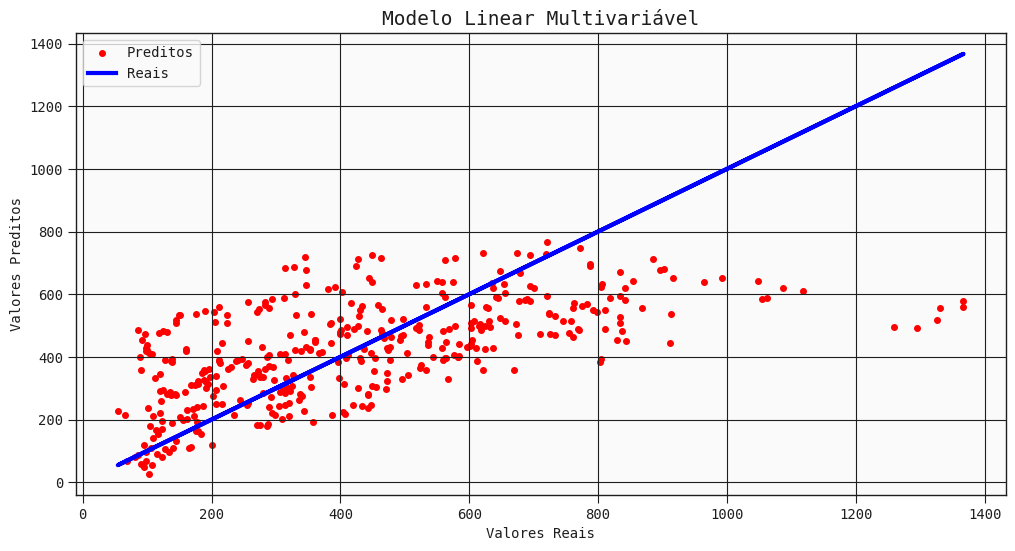

In [34]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred_linear, color='red', label='Preditos')
plt.plot(y_test, y_test, color='blue', label='Reais', linestyle='-')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Modelo Linear Multivariável")
plt.grid()
plt.legend()
plt.show()


## Resíduos

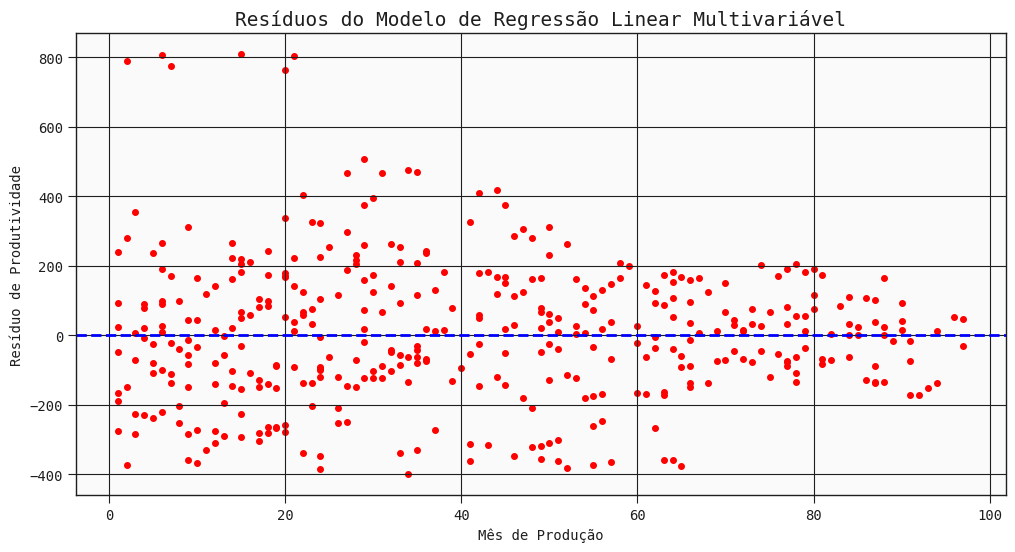

In [35]:
residuos_linear = test_dataset['Produtividade'].values - y_test_pred_linear.flatten()

mean_mesproducao = scaler.mean_[2]
std_mesproducao = scaler.scale_[2]
mesproducao_desnormalizado = test_dataset['MesProducao'] * std_mesproducao + mean_mesproducao

plt.figure(figsize=(12, 6))
plt.scatter(mesproducao_desnormalizado, residuos_linear, color='red', marker='o')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=2)
plt.title('Resíduos do Modelo de Regressão Linear Multivariável')
plt.xlabel('Mês de Produção')
plt.ylabel('Resíduo de Produtividade')
plt.grid(True)
plt.show()


# Polinomial

## Implementação

In [36]:
modelo_poli = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])

modelo_poli.fit(x_train, y_train)

y_train_pred_poli = modelo_poli.predict(x_train)
y_test_pred_poli = modelo_poli.predict(x_test)

r2 = r2_score(y_test, y_test_pred_poli)
mae = mean_absolute_error(y_test, y_test_pred_poli)
rmse = root_mean_squared_error(y_test, y_test_pred_poli)

print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


R2: 0.4788
MAE: 140.18
RMSE: 187.88


## Plot Paridade

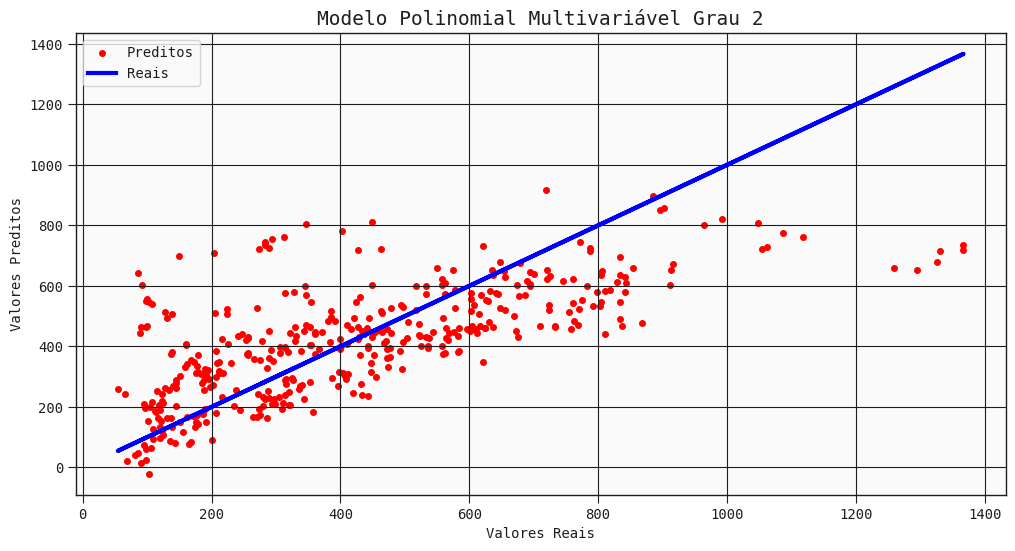

In [37]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred_poli, color='red', label='Preditos')
plt.plot(y_test, y_test, color='blue', label='Reais', linestyle='-')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Modelo Polinomial Multivariável Grau 2")
plt.grid()
plt.legend()
plt.show()


## Resíduos

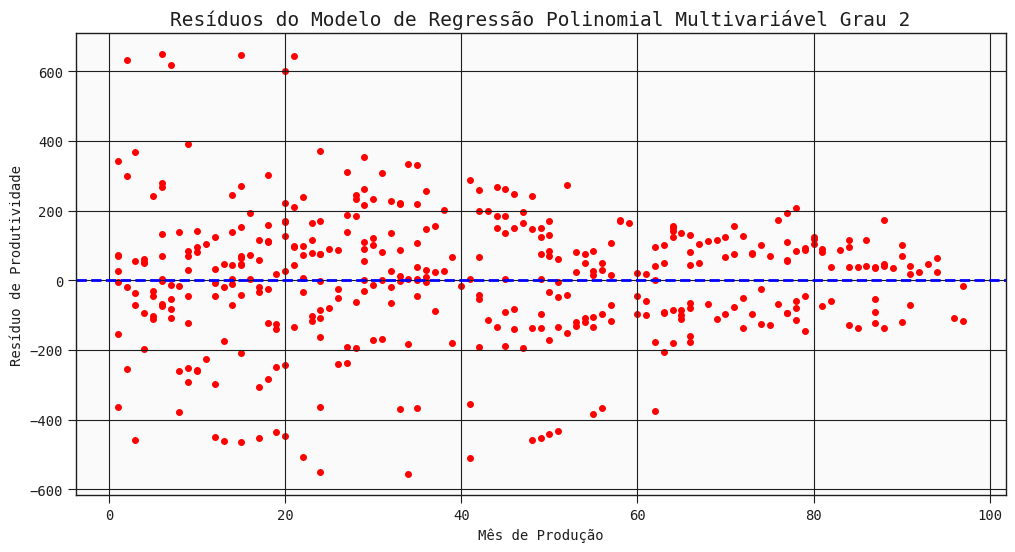

In [38]:
residuos_poli = test_dataset['Produtividade'].values - y_test_pred_poli.flatten()

mean_mesproducao = scaler.mean_[2]
std_mesproducao = scaler.scale_[2]
mesproducao_desnormalizado = test_dataset['MesProducao'] * std_mesproducao + mean_mesproducao

plt.figure(figsize=(12, 6))
plt.scatter(mesproducao_desnormalizado, residuos_poli, color='red', marker='o')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=2)
plt.title('Resíduos do Modelo de Regressão Polinomial Multivariável Grau 2')
plt.xlabel('Mês de Produção')
plt.ylabel('Resíduo de Produtividade')
plt.grid(True)
plt.show()


# Regressão Simbólica (Feyn)

## Implementação

In [39]:
ql = feyn.QLattice()
models = ql.auto_run(data=train_dataset, output_name='Produtividade')


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="216.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 1023 216.0" width="1023" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="711" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="601" y="50.0"><title>Produtividade
linear:
scale=656.523287
scale offset=0.000000
w=2.752212
bias=-1.0866</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="646.0" y="71.5">Produtiv..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="689" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="603" y="59.0">out</text><line stroke="#1E1E1E" x1="571" x2="601" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="481" y="50.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="71.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="59.0">1</text><line stroke="#1E1E1E" x1="451" x2="481" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="451" x2="481" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="20.0"><title>MesProducao
linear:
scale=0.538385
scale offset=0.006221
w=0.224143
bias=0.2503</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="41.5">MesProdu..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="29.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="80.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="101.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="89.0">3</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="20.0"><title>Latitude
linear:
scale=0.597535
scale offset=0.008694
w=-0.096622
bias=-0.4385</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">Latitude</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="80.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="101.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="89.0">5</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><tit
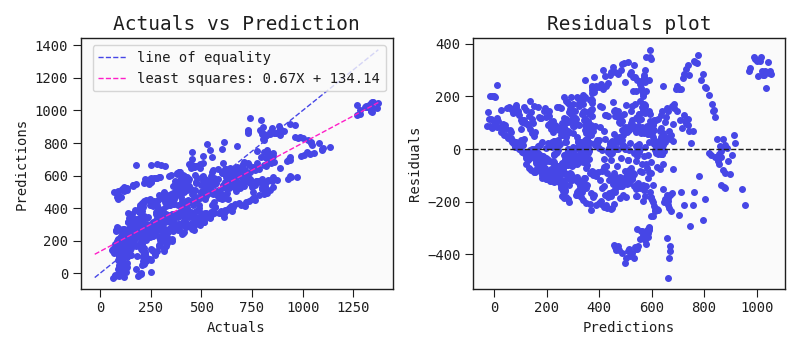
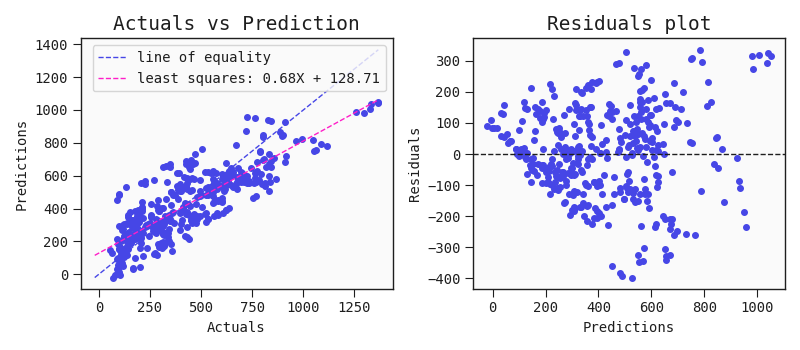

In [40]:
best = models[0]
best.plot(train_dataset, test_dataset)


## Plot Paridade

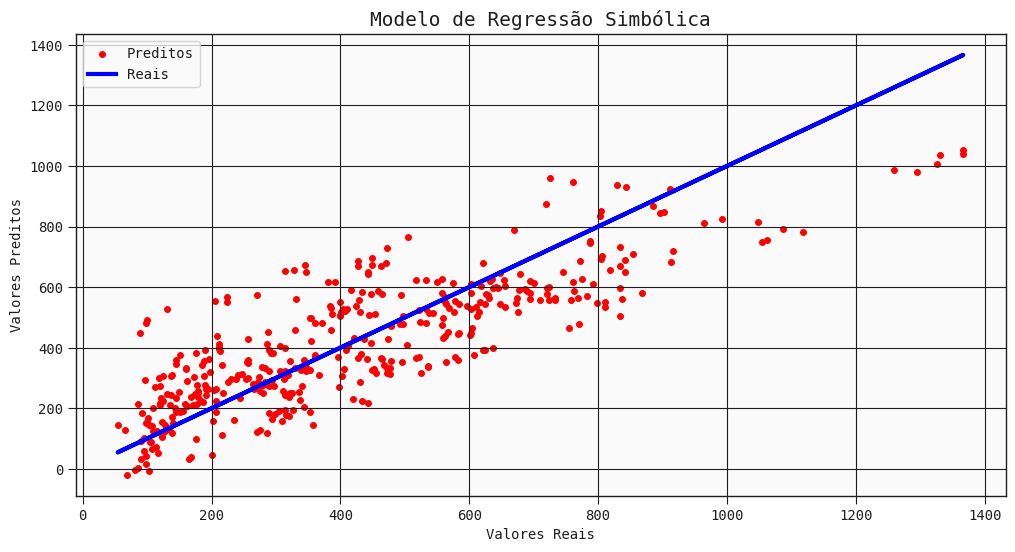

In [41]:
y_true = test_dataset['Produtividade'].values
y_test_pred_sr = best.predict(test_dataset)

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred_sr, color='red', label='Preditos')
plt.plot(y_test, y_test, color='blue', label='Reais', linestyle='-')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Modelo de Regressão Simbólica")
plt.grid()
plt.legend()
plt.show()


## Resíduos

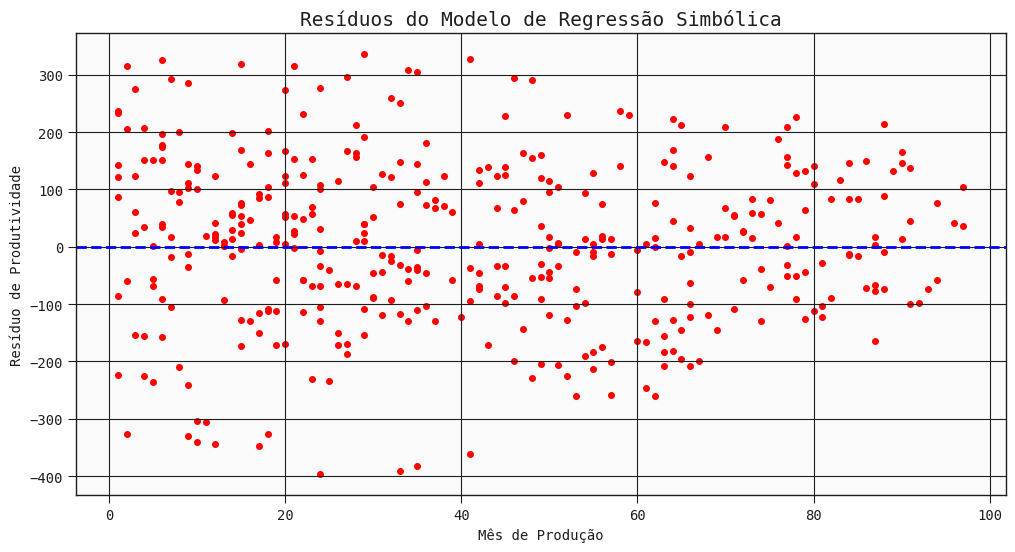

In [42]:
residuos_sr = test_dataset['Produtividade'].values - y_test_pred_sr.flatten()

mean_mesproducao = scaler.mean_[2]
std_mesproducao = scaler.scale_[2]
mesproducao_desnormalizado = test_dataset['MesProducao'] * std_mesproducao + mean_mesproducao

plt.figure(figsize=(12, 6))
plt.scatter(mesproducao_desnormalizado, residuos_sr, color='red', marker='o')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=2)
plt.title('Resíduos do Modelo de Regressão Simbólica')
plt.xlabel('Mês de Produção')
plt.ylabel('Resíduo de Produtividade')
plt.grid(True)
plt.show()


## String Model
Converte o modelo em expressão algébrica (simpify)

In [43]:
sympy_model = best.sympify(symbolic_cat=False, symbolic_lr=True)
string_model = sp.sstr(sympy_model).replace("exp", "np.exp").replace('tanh','np.tanh').replace('log', 'np.log').replace('sqrt', 'np.sqrt')

def model_inference(MesProducao, Latitude, Longitude):
    return eval(string_model)

expressao_algebrica = string_model
expressao_algebrica = expressao_algebrica.replace("Longitude", "x")
expressao_algebrica = expressao_algebrica.replace("Latitude", "y")
expressao_algebrica = expressao_algebrica.replace("MesProducao", "t")
expressao_algebrica = expressao_algebrica.replace("np.exp", "exp").replace('np.tanh','tanh').replace('np.log', 'log').replace('np.sqrt', 'sqrt')
expressao_algebrica = expressao_algebrica.replace("**", "^")
expressao_algebrica = expressao_algebrica.replace(".", ",")

print('P =',expressao_algebrica)


P = 1806,89*exp(-0,124558*(0,483557*t + 1)^2 - 2,0*(-0,057735*y + exp(-38,0471*(0,365022 - y)^4 - 0,00490441*(t - 0,218033)^2) - 0,438038)^2) - 713,351


# Rede Neural (Tensorflow)

## Implementação

In [44]:
l1_value = l2_value = 0.001
fator_dropout = 0.2
funcao_ativacao = 'relu'
otimizador = tf.keras.optimizers.Adam(learning_rate=0.01)
neuronios_por_camada = 256
batches = 32
    
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(neuronios_por_camada, activation=funcao_ativacao, kernel_regularizer=tf.keras.regularizers.l2(l2=l2_value)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(fator_dropout),
    tf.keras.layers.Dense(neuronios_por_camada, activation=funcao_ativacao, kernel_regularizer=tf.keras.regularizers.l2(l2=l2_value)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(fator_dropout),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=otimizador, loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = model.fit(x_train, y_train, 
          epochs=200,
          verbose=0,
          batch_size = batches,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping])

y_pred_test = model.predict(x_test)
y_pred_train = model.predict(x_train)

test_r2_tf = r2_score(y_test, y_pred_test)
test_mae_tf = mean_absolute_error(y_test, y_pred_test)
test_rmse_tf = root_mean_squared_error(y_test, y_pred_test)

train_r2_tf = r2_score(y_train, y_pred_train)
train_mae_tf = mean_absolute_error(y_train, y_pred_train)
train_rmse_tf = root_mean_squared_error(y_train, y_pred_train)

print("Dados de Treinamento")
print(f"R2: {train_r2_tf:.4f}, MAE: {train_mae_tf:.2f}, RMSE: {train_rmse_tf:.2f}")

print("Dados de Teste")
print(f"R2: {test_r2_tf:.4f}, MAE: {test_mae_tf:.2f}, RMSE: {test_rmse_tf:.2f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
Dados de Treinamento
R2: 0.8700, MAE: 66.19, RMSE: 97.73
Dados de Teste
R2: 0.8821, MAE: 63.51, RMSE: 89.36


## Curva de Aprendizado

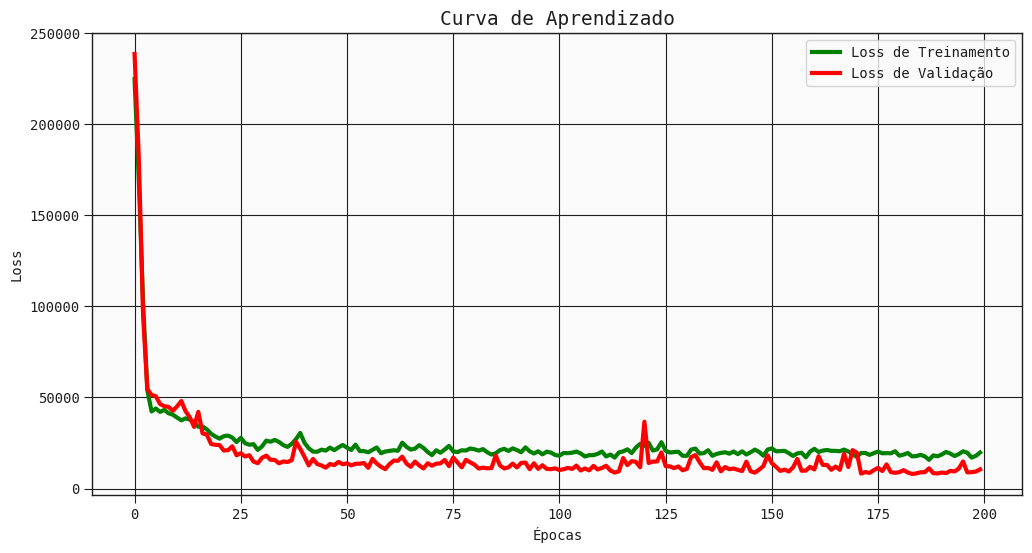

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss de Treinamento', color='green')
plt.plot(history.history['val_loss'], label='Loss de Validação', color='red')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Curva de Aprendizado")
plt.legend()
plt.grid()
plt.show()


## Plot Paridade

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


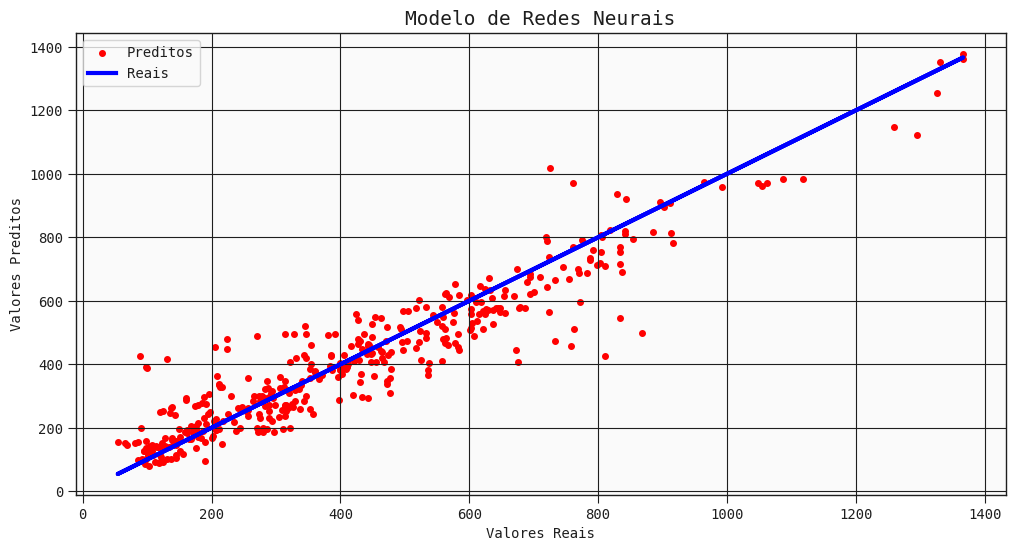

In [46]:
y_pred_tf = model.predict(test_dataset[['Latitude', 'Longitude', 'MesProducao']])


plt.figure(figsize=(12, 6))
plt.scatter(test_dataset['Produtividade'].values, y_pred_tf.flatten(), color='red', label='Preditos')
plt.plot(test_dataset['Produtividade'].values, test_dataset['Produtividade'].values, color='blue', label='Reais', linestyle='-')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Modelo de Redes Neurais")
plt.grid()
plt.legend()
plt.show()


## Resíduos

In [47]:
mean_mesproducao = scaler.mean_[2]
std_mesproducao = scaler.scale_[2]

mesproducao_desnormalizado = test_dataset['MesProducao'] * std_mesproducao + mean_mesproducao

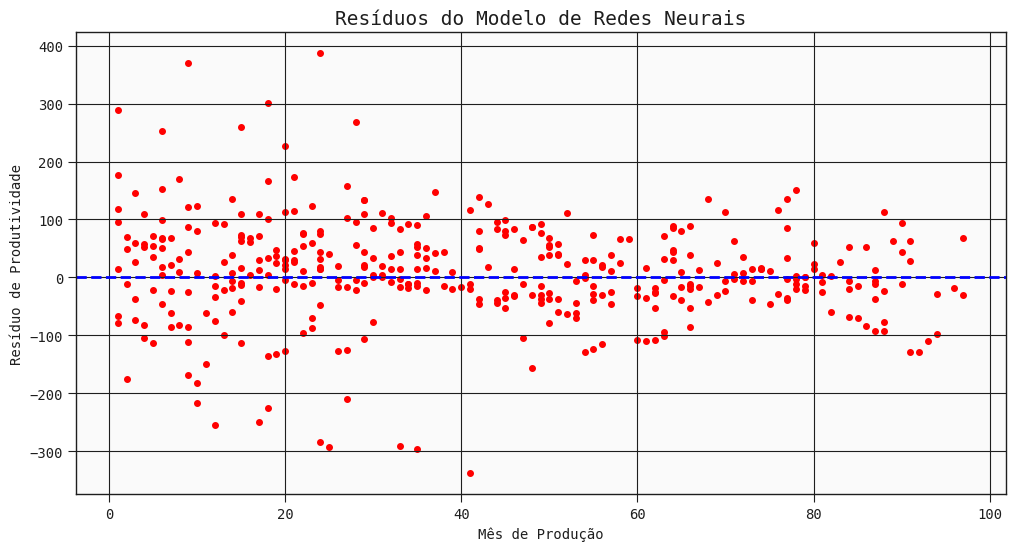

In [48]:
residuos_tf = test_dataset['Produtividade'].values - y_pred_tf.flatten()

plt.figure(figsize=(12, 6))
plt.scatter(mesproducao_desnormalizado, residuos_tf, color='red', marker='o', alpha=1)
plt.axhline(y=0, color='blue', linestyle='--', linewidth=2)
plt.title('Resíduos do Modelo de Redes Neurais')
plt.xlabel('Mês de Produção')
plt.ylabel('Resíduo de Produtividade')
plt.grid(True)
plt.show()


# Arps

## Ajuste de Parâmetros

Ajuste de Parâmetros do Modelo Hiperbólico:
- qi=637.57
- Di=0.0113
- b=0.00000000



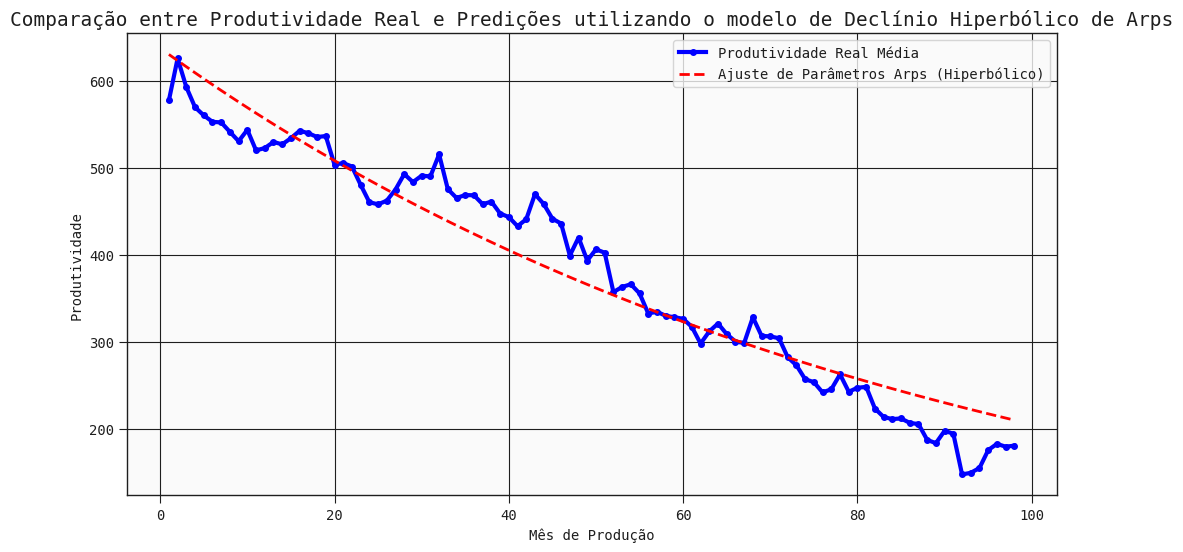

R2: 0.9329
MAE: 27.49
RMSE: 33.58


In [49]:
def hyperbolic_decline(t, qi, Di, b):
    return qi / (1 + b * Di * t)**(1/b)

df_campo_media = df_campo_analise.groupby('MesProducao')['Produtividade'].mean().reset_index()

t_data = df_campo_media['MesProducao'].values
q_data = df_campo_media['Produtividade'].values

popt_hyperbolic, _ = curve_fit(hyperbolic_decline, t_data, q_data, bounds=(0, [1000, 1, 1]))
qi_hyperbolic, Di_hyperbolic, b_hyperbolic = popt_hyperbolic

t_forecast = np.linspace(t_data.min(), t_data.max(), len(t_data))
q_forecast_hyperbolic = hyperbolic_decline(t_forecast, qi_hyperbolic, Di_hyperbolic, b_hyperbolic)

print(f"Ajuste de Parâmetros do Modelo Hiperbólico:\n- qi={qi_hyperbolic:.2f}\n- Di={Di_hyperbolic:.4f}\n- b={b_hyperbolic:.8f}\n")

plt.figure(figsize=(12, 6))
plt.plot(df_campo_media['MesProducao'], df_campo_media['Produtividade'], color='blue', label='Produtividade Real Média', marker='o', linestyle='-')
plt.plot(t_forecast, q_forecast_hyperbolic, color='red', linewidth=2, label='Ajuste de Parâmetros Arps (Hiperbólico)', linestyle='--')
plt.title('Comparação entre Produtividade Real e Predições utilizando o modelo de Declínio Hiperbólico de Arps')
plt.xlabel('Mês de Produção')
plt.ylabel('Produtividade')
plt.legend()
plt.grid(True)
plt.show()

r2_hyperbolic = r2_score(df_campo_media['Produtividade'], q_forecast_hyperbolic)
rmse_hyperbolic = root_mean_squared_error(df_campo_media['Produtividade'], q_forecast_hyperbolic)
mae_hyperbolic = mean_absolute_error(df_campo_media['Produtividade'], q_forecast_hyperbolic)

print(f"R2: {r2_hyperbolic:.4f}")
print(f"MAE: {mae_hyperbolic:.2f}")
print(f"RMSE: {rmse_hyperbolic:.2f}")


## Resíduos

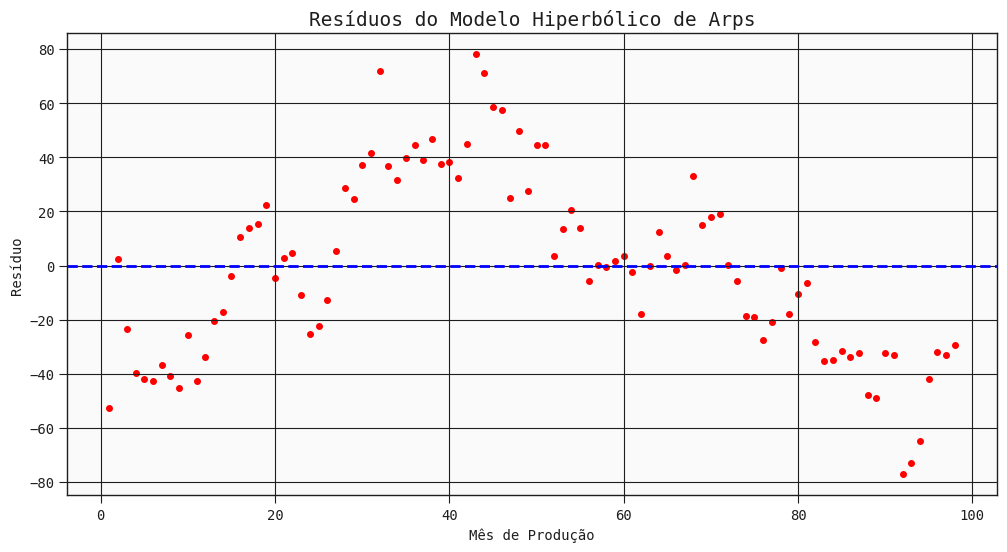

In [50]:
residuos_arps = df_campo_media['Produtividade'] - q_forecast_hyperbolic

plt.figure(figsize=(12, 6))
plt.scatter(df_campo_media['MesProducao'], residuos_arps, color='red', marker='o')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=2)
plt.title('Resíduos do Modelo Hiperbólico de Arps')
plt.xlabel('Mês de Produção')
plt.ylabel('Resíduo')
plt.grid(True)
plt.show()


# Hubbert

## Ajuste de Parâmetros

Ajuste de Parâmetros do Modelo de Hubbert:
- q_max=643.51
- a=0.0327
- t_peak=63.37



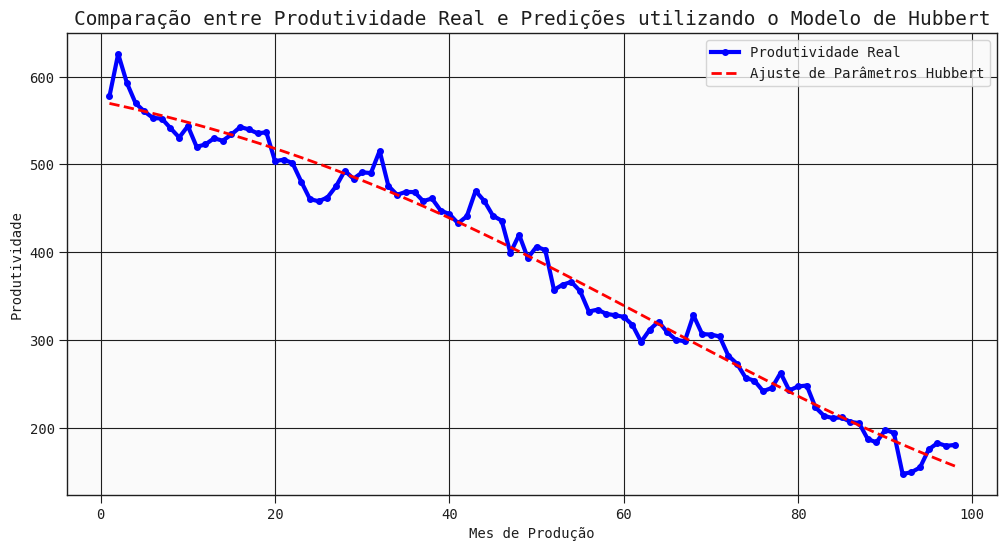

R2: 0.9800
R2: 14.26
R2: 18.32


In [51]:
def hubbert_curve(t, q_max, a, t_peak):
    return q_max / (1 + np.exp(a * (t - t_peak)))


df_campo_media = df_campo_analise.groupby('MesProducao')['Produtividade'].mean().reset_index()

t_data = df_campo_media['MesProducao'].values
q_data = df_campo_media['Produtividade'].values

initial_guess = [max(q_data), 0.1, np.median(t_data)]

popt_hubbert, _ = curve_fit(hubbert_curve, t_data, q_data, p0=initial_guess)
q_max_fit, a_fit, t_peak_fit = popt_hubbert


t_forecast = np.linspace(t_data.min(), t_data.max(), len(t_data))

q_forecast_hubbert = hubbert_curve(t_forecast, q_max_fit, a_fit, t_peak_fit)

print(f"Ajuste de Parâmetros do Modelo de Hubbert:\n- q_max={q_max_fit:.2f}\n- a={a_fit:.4f}\n- t_peak={t_peak_fit:.2f}\n")

plt.figure(figsize=(12, 6))
plt.plot(df_campo_media['MesProducao'], df_campo_media['Produtividade'], color='blue', label='Produtividade Real', marker='o', linestyle='-')
plt.plot(t_forecast, q_forecast_hubbert, color='red', linewidth=2, label='Ajuste de Parâmetros Hubbert', linestyle='--')
plt.title('Comparação entre Produtividade Real e Predições utilizando o Modelo de Hubbert')
plt.xlabel('Mes de Produção')
plt.ylabel('Produtividade')
plt.legend()
plt.grid(True)
plt.show()

r2_hubbert = r2_score(df_campo_media['Produtividade'], q_forecast_hubbert)
rmse_hubbert = root_mean_squared_error(df_campo_media['Produtividade'], q_forecast_hubbert)
mae_hubbert = mean_absolute_error(df_campo_media['Produtividade'], q_forecast_hubbert)

print(f"R2: {r2_hubbert:.4f}")
print(f"R2: {mae_hubbert:.2f}")
print(f"R2: {rmse_hubbert:.2f}")


## Resíduos

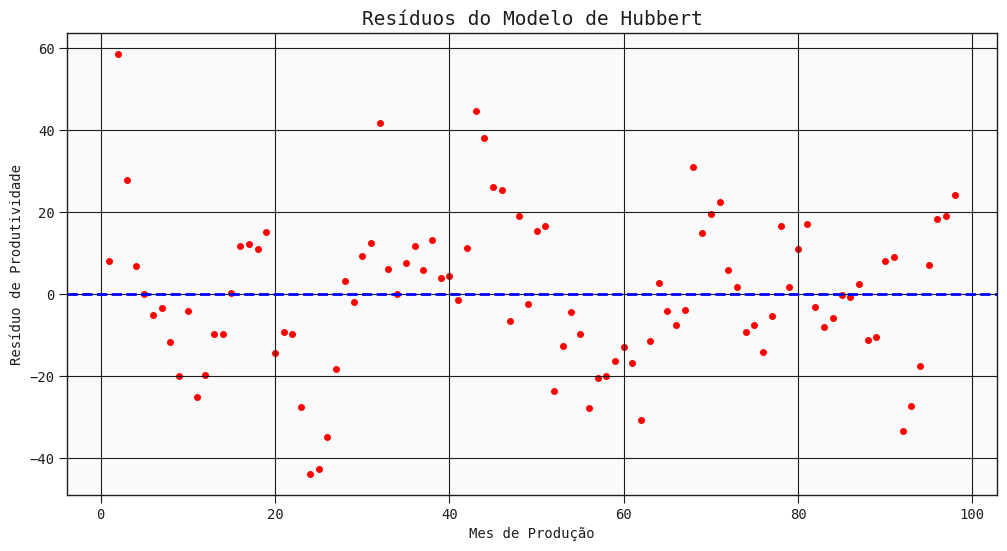

In [53]:
residuos_hubbert = df_campo_media['Produtividade'] - q_forecast_hubbert

plt.figure(figsize=(12, 6))
plt.scatter(df_campo_media['MesProducao'], residuos_hubbert, color='red', marker='o')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=2)
plt.title('Resíduos do Modelo de Hubbert')
plt.xlabel('Mes de Produção')
plt.ylabel('Resíduo de Produtividade')
plt.grid(True)
plt.show()
